In [1]:
import cv2
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys

from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [2]:
# Function to load the images given the folder name
def load_path(path):
    imgs = []
    files = listdir('./MIO-TCD-Classification/train/{}/'.format(path))
    img_counter = 1
    for img in files:
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Classification/train/{}/{}'.format(path,img)), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,128))
        imgs.append(img)
        img_counter += 1
        if(img_counter==1001): break
    return imgs

In [3]:
articulated_truck = load_path('articulated_truck')
background = load_path('background')
bicycle = load_path('bicycle')
bus = load_path('bus')
car = load_path('car')
motorcycle = load_path('motorcycle')
non_motorized_vehicle = load_path('non-motorized_vehicle')
pedestrian = load_path('pedestrian')
pickup_truck = load_path('pickup_truck')
single_unit_truck = load_path('single_unit_truck')
work_van = load_path('work_van')

In [4]:
X = articulated_truck + background + bicycle + bus + car + motorcycle + non_motorized_vehicle + pedestrian + pickup_truck + single_unit_truck + work_van

y = ['articulated_truck']*1000 + ['background']*1000 + ['bicycle']*1000 + ['bus']*1000 + ['car']*1000 + ['motorcycle']*1000 + ['non_motorized_vehicle']*1000 + ['pedestrian']*1000 + ['pickup_truck']*1000 + ['single_unit_truck']*1000 + ['work_van']*1000


In [5]:
# Function to compute HoG features of a list of images
def compute_HoG(imgs, cell_size, block_size, nbins, h, w):
    img_features = []
    hog = cv2.HOGDescriptor(_winSize=((w // cell_size[1]) * cell_size[1],
                                  (h // cell_size[0]) * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    n_cells = (h // cell_size[0], w // cell_size[1])
    
    for img in imgs:

        hog_feats = hog.compute(img)\
                .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        # computation for BlockNorm

        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        
        img_features.append(gradients)
        
    return img_features
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)


c_size = (4,4)
b_size = (4,4)
bins = 8
height = 128
width = 128

HoG_feat = compute_HoG(X_train, c_size, b_size, bins, height, width)

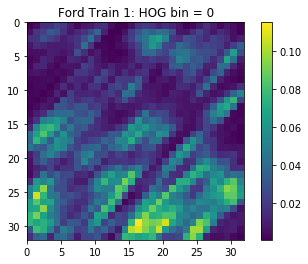

In [7]:
bin = 0
test = HoG_feat[0]
plt.pcolor(test[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Ford Train 1: HOG bin = 0")
plt.colorbar()
plt.show()

In [8]:
# Part 4

clf = KNeighborsClassifier()
HoG_feat = np.array(HoG_feat)
clf.fit(HoG_feat.reshape(HoG_feat.shape[0],-1),y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')